In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from math import sqrt

np.random.seed(42)
tensorflow.random.set_seed(42)


In [186]:
AAPL_values = yf.download('AAPL', start='2019-01-01', end='2024-01-01')
AAPL_values

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845047,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075394,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530048,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450966,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126774,164101200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700


Text(0.5, 1.0, 'AAPL stock price')

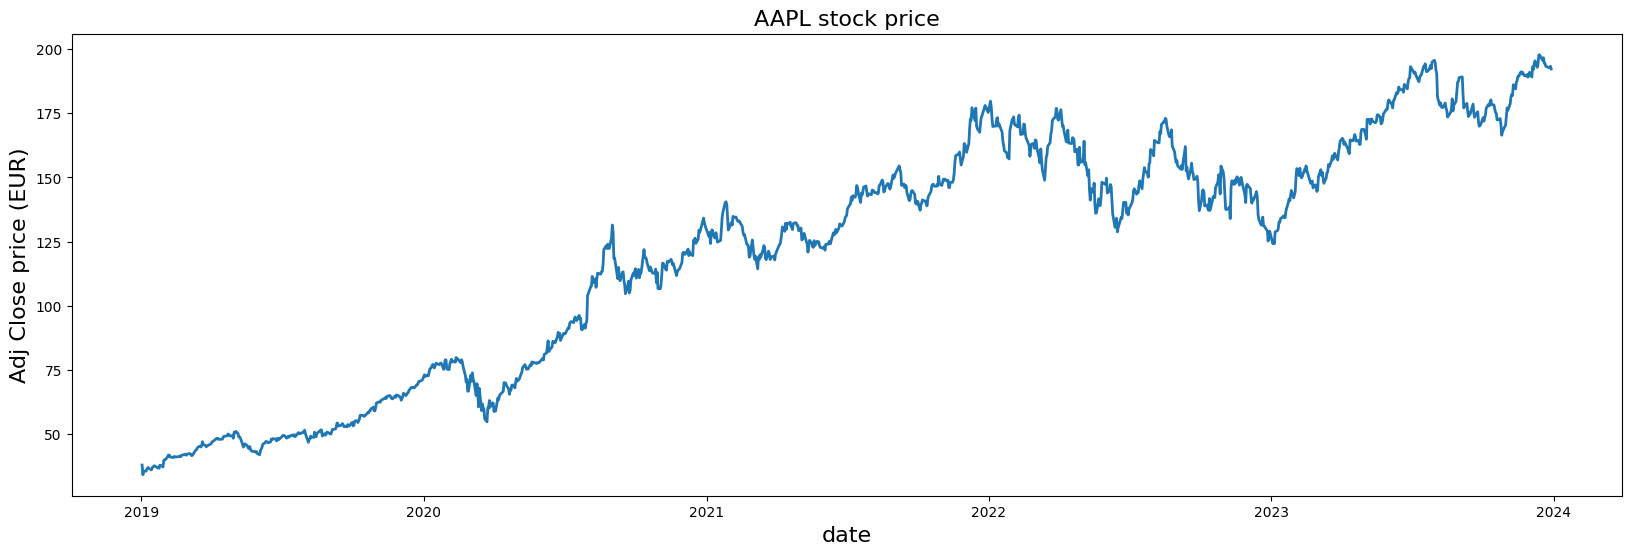

In [187]:
plt.figure(figsize=(20,6))
plt.plot(AAPL_values.index, AAPL_values['Adj Close'], lw=2)
plt.xlabel("date")
plt.xlabel("date", fontsize=16)
plt.ylabel("Adj Close price (EUR)", fontsize=16)
plt.title("AAPL stock price", fontsize=16)

In [188]:
# convert the Date column into a pandas datatime format
AAPL_values.index = pd.to_datetime(AAPL_values.index)

In [189]:
scaler = MinMaxScaler(feature_range=(0, 1))
AAPL_values['Adj Close'] = scaler.fit_transform(AAPL_values[['Adj Close']])

In [190]:
# train / test split
train_data = AAPL_values[:int(0.8*len(AAPL_values))].reset_index(drop=False)
test_data  = AAPL_values[int(0.8*len(AAPL_values)):].reset_index(drop=False)

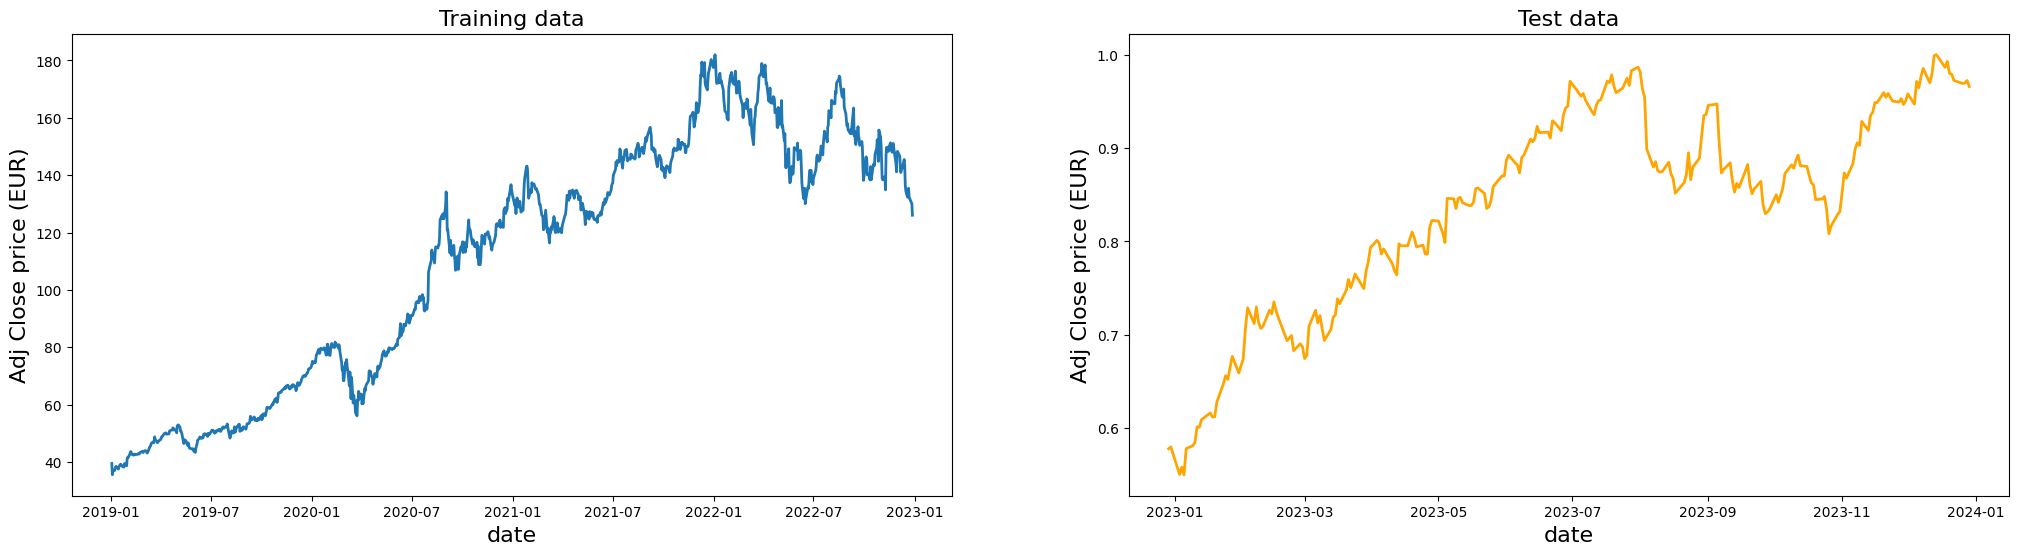

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
ax1.plot(train_data.Date, train_data['Close'], lw=2)
ax1.set_xlabel("date", fontsize=16)
ax1.set_ylabel("Adj Close price (EUR)", fontsize=16)
ax1.set_title("Training data", fontsize=16)
ax2.plot(test_data.Date, test_data['Adj Close'], c='orange', lw=2)
ax2.set_xlabel("date", fontsize=16)
ax2.set_ylabel("Adj Close price (EUR)", fontsize=16)
ax2.set_title("Test data", fontsize=16);

In [192]:
X_train = train_data.Date
y_train = train_data['Adj Close']
X_test = test_data.Date
y_test = test_data['Adj Close']

In [193]:
n_features = 1
train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))

In [194]:
look_back = 20
x_days_ahead = 5

train_generator = TimeseriesGenerator(train_series[:len(train_series) - x_days_ahead + 1], train_series[x_days_ahead - 1:],
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series[:len(test_series)-x_days_ahead+1], test_series[x_days_ahead-1:],
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

c:\Users\gurgu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


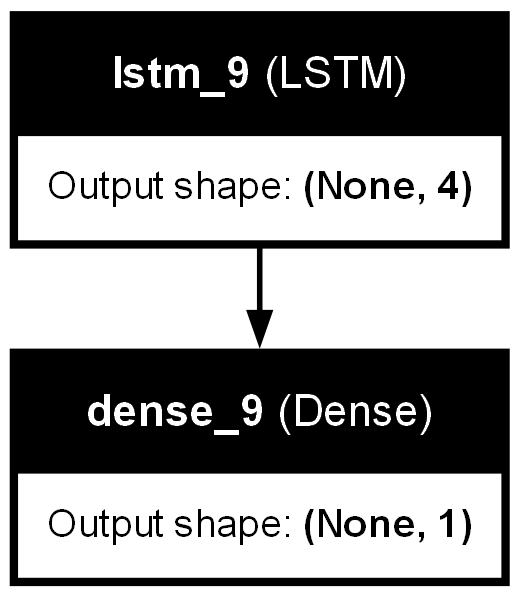

In [195]:
look_back = 20  # ensure this is defined, same with n_features
n_features = 1  # example value, set this according to your actual data features
n_neurons = 4

model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [196]:
model.fit(train_generator,epochs=300, verbose=2)

Epoch 1/300


c:\Users\gurgu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 - 1s - 13ms/step - loss: 0.1375
Epoch 2/300
99/99 - 0s - 2ms/step - loss: 0.0400
Epoch 3/300
99/99 - 0s - 2ms/step - loss: 0.0210
Epoch 4/300
99/99 - 0s - 2ms/step - loss: 0.0095
Epoch 5/300
99/99 - 0s - 3ms/step - loss: 0.0036
Epoch 6/300
99/99 - 0s - 3ms/step - loss: 0.0019
Epoch 7/300
99/99 - 0s - 3ms/step - loss: 0.0015
Epoch 8/300
99/99 - 0s - 3ms/step - loss: 0.0016
Epoch 9/300
99/99 - 0s - 3ms/step - loss: 0.0015
Epoch 10/300
99/99 - 0s - 2ms/step - loss: 0.0015
Epoch 11/300
99/99 - 0s - 2ms/step - loss: 0.0015
Epoch 12/300
99/99 - 0s - 3ms/step - loss: 0.0015
Epoch 13/300
99/99 - 0s - 3ms/step - loss: 0.0015
Epoch 14/300
99/99 - 0s - 3ms/step - loss: 0.0015
Epoch 15/300
99/99 - 0s - 2ms/step - loss: 0.0014
Epoch 16/300
99/99 - 0s - 3ms/step - loss: 0.0014
Epoch 17/300
99/99 - 0s - 3ms/step - loss: 0.0015
Epoch 18/300
99/99 - 0s - 3ms/step - loss: 0.0014
Epoch 19/300
99/99 - 0s - 3ms/step - loss: 0.0015
Epoch 20/300
99/99 - 0s - 2ms/step - loss: 0.0015
Epoch 21/300
99/99 -

In [197]:
X_test[look_back:]

20    2023-01-30
21    2023-01-31
22    2023-02-01
23    2023-02-02
24    2023-02-03
         ...    
247   2023-12-22
248   2023-12-26
249   2023-12-27
250   2023-12-28
251   2023-12-29
Name: Date, Length: 232, dtype: datetime64[ns]

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Text(0.5, 1.0, 'AAPL stock price scaled predictions 5 days ahead')

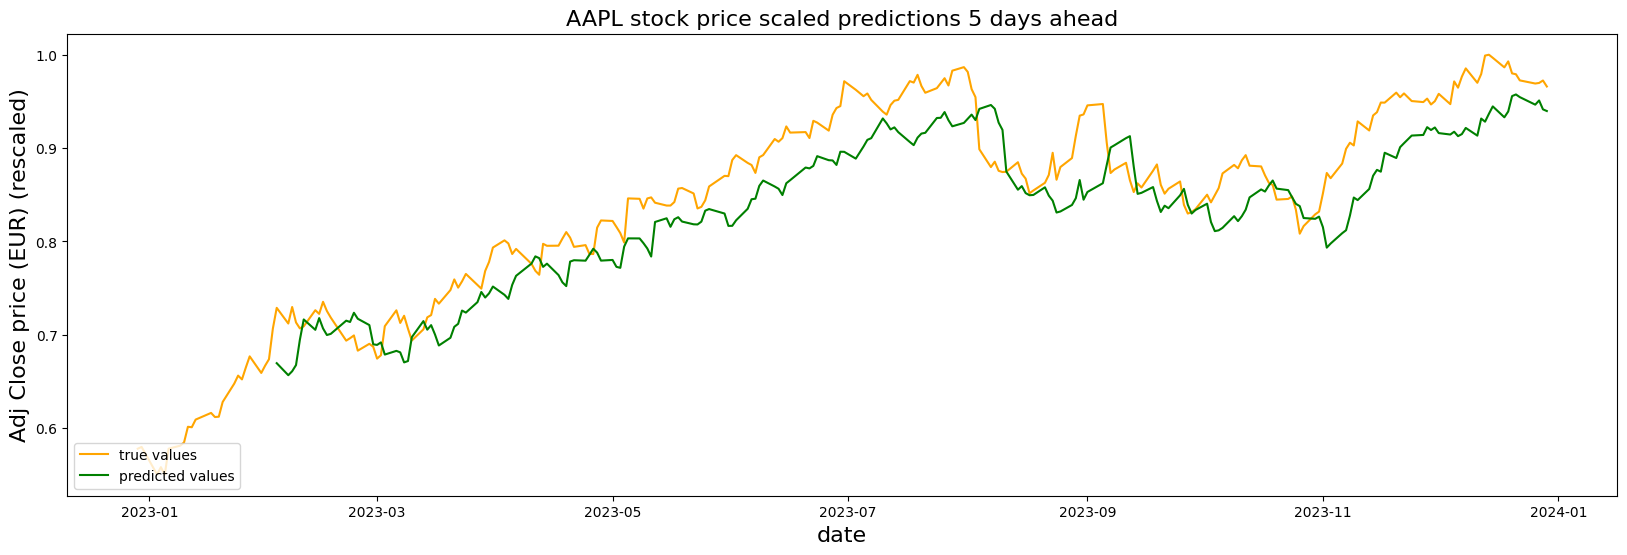

In [198]:
test_predictions  = model.predict(test_generator)

plt.figure(figsize=(20,6))
plt.plot(test_data.Date, test_data['Adj Close'], c='orange',label='true values')
plt.plot(X_test[look_back + x_days_ahead - 1:], test_predictions, c='green',label='predicted values')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Adj Close price (EUR) (rescaled)", fontsize=16)
plt.title(f"AAPL stock price scaled predictions {x_days_ahead} days ahead", fontsize=16)

Text(0.5, 1.0, 'AAPL stock price predictions 5 days ahead')

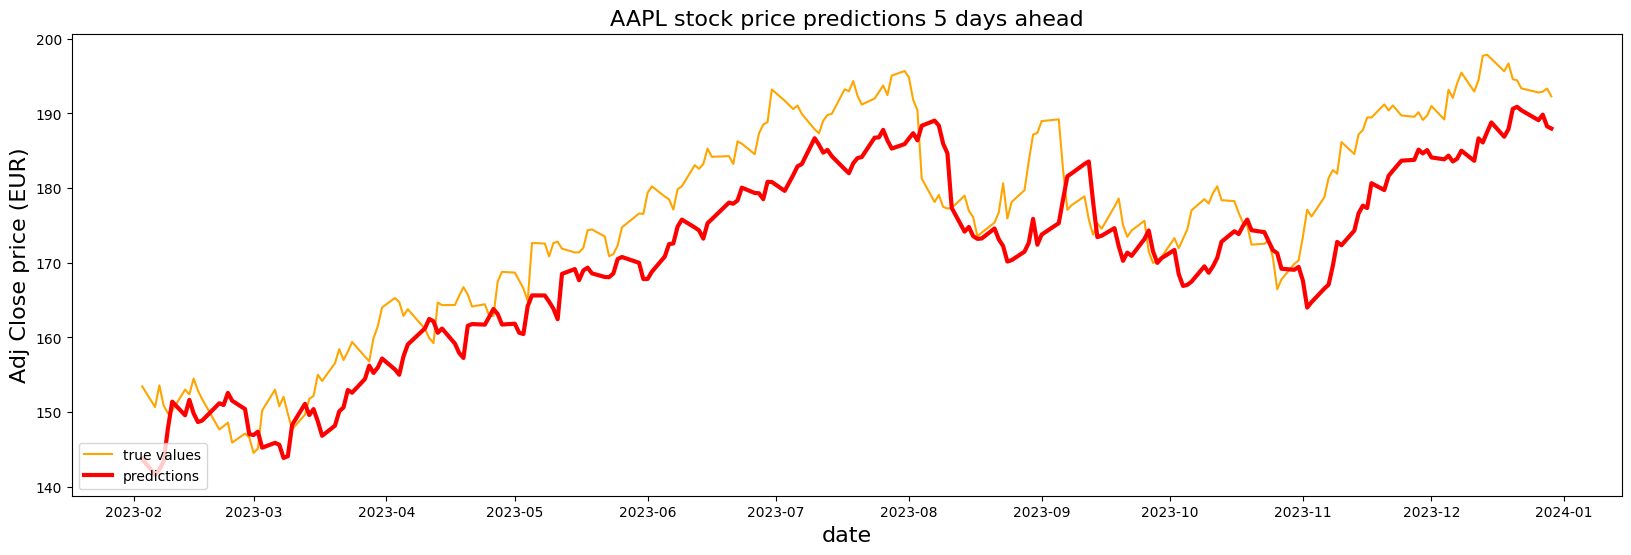

In [199]:
inverted_scale_predictions = scaler.inverse_transform(test_predictions)
inverted_scale_test = scaler.inverse_transform(test_series[look_back + x_days_ahead - 1:])

plt.figure(figsize=(20,6))
plt.plot(test_data.Date[look_back + x_days_ahead - 1:], inverted_scale_test, c='orange',label='true values')
plt.plot(test_data.Date[look_back + x_days_ahead - 1:], inverted_scale_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Adj Close price (EUR)", fontsize=16)
plt.title(f"AAPL stock price predictions {x_days_ahead} days ahead", fontsize=16)

In [200]:
rmse = sqrt(mean_squared_error(inverted_scale_test, inverted_scale_predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.917
